# On the Unbalanced Data (Mild)

## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import random

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from collections import defaultdict

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

## confusion matrix
confusion_ce = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_l1 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal2 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal05 = np.zeros((NUM_CLASS, NUM_CLASS))

### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)


test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### 1.4 Creating an Unbalanced Training Set

In [5]:

samples_per_class = {
    0: 4000,
    1: 3500,
    2: 4500,
    3: 500,
    4: 200,
    5: 4000,
    6: 4500,
    7: 4200,
    8: 4250,
    9: 4000
}



samples_grouped_by_class = defaultdict(list)
for sample in train_set:
    label = sample[1]
    samples_grouped_by_class[label].append(sample)


selected_samples = []
for label, count in samples_per_class.items():
    selected_samples.extend(random.sample(samples_grouped_by_class[label], count))

train_set = selected_samples

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## 2. Model

## 2.1 Define the Neural Network

In [6]:
## this is the model for Cross Entropy, since nn.crossentropy is equipped with a softmax layer, here we do not employ a softmax layer
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 

        return x


In [7]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss

class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 
        x = nn.Softmax(dim=1)(x) 
        return x


### 2.2 Define the Loss Functions and train_batch, testing_batch

In [8]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [9]:
##################### Define the 4 required Loss Functions##################
CrossEntropy = nn.CrossEntropyLoss()
L1Loss = nn.L1Loss()
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_2 = FocalLoss(gamma=2)
###############################################################

In [10]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [11]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

## 3.  Model Training with Different Loss Functions

### 3.1 CrossEntropy

In [12]:
## initial the model for Cross Entropy

model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss_CE = []
training_acc_CE = []
testing_loss_CE = []
testing_acc_CE = []

all_targets = []
all_preds = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target, CrossEntropy)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
          
    training_loss_CE.append(epoch_loss)
    training_acc_CE.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target, CrossEntropy)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
        

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_CE.append(val_loss)
        testing_acc_CE.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_CE = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_CE, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0124 Acc: 0.4215
Begin test......
Test Loss: 0.0155 Acc: 0.4477
Epoch: 2/30 Train Loss: 0.0098 Acc: 0.5525
Begin test......
Test Loss: 0.0138 Acc: 0.4916
Epoch: 3/30 Train Loss: 0.0086 Acc: 0.6192
Begin test......
Test Loss: 0.0121 Acc: 0.5386
Epoch: 4/30 Train Loss: 0.0079 Acc: 0.6552
Begin test......
Test Loss: 0.0119 Acc: 0.5557
Epoch: 5/30 Train Loss: 0.0072 Acc: 0.6862
Begin test......
Test Loss: 0.0120 Acc: 0.5432
Epoch: 6/30 Train Loss: 0.0060 Acc: 0.7399
Begin test......
Test Loss: 0.0111 Acc: 0.5821
Epoch: 7/30 Train Loss: 0.0054 Acc: 0.7638
Begin test......
Test Loss: 0.0118 Acc: 0.5838
Epoch: 8/30 Train Loss: 0.0052 Acc: 0.7753
Begin test......
Test Loss: 0.0115 Acc: 0.5737
Epoch: 9/30 Train Loss: 0.0049 Acc: 0.7875
Begin test......
Test Loss: 0.0118 Acc: 0.5767
Epoch: 10/30 Train Loss: 0.0046 Acc: 0.7969
Begin test......
Test Loss: 0.0116 Acc: 0.5839
Epoch: 11/30 Train Loss: 0.0037 Acc: 0.8410
Begin test......
Test Loss: 0.0123 Acc: 0.5937
Epoch: 1

In [14]:
confusion_ce = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_ce, recall_ce, f1_ce, _ce = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_ce = np.mean(precision_ce)
macro_recall_ce = np.mean(recall_ce)
macro_f1_ce = np.mean(f1_ce)
micro_precision_ce, micro_recall_ce, micro_f1_ce, _ce = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_ce:.4f} Macro Recall: {macro_recall_ce:.4f} Macro F1: {macro_f1_ce:.4f}')
print(f'Micro Precision: {micro_precision_ce:.4f} Micro Recall: {micro_recall_ce:.4f} Micro F1: {micro_f1_ce:.4f}')

Macro Precision: 0.5964 Macro Recall: 0.5744 Macro F1: 0.5262
Micro Precision: 0.5744 Micro Recall: 0.5744 Micro F1: 0.5744


### 3.2 L1Loss

In [15]:
## initial the model for L1 Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

In [17]:
training_loss_L1 = []
training_acc_L1 = []
testing_loss_L1 = []
testing_acc_L1 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, L1Loss)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_L1.append(epoch_loss)
    training_acc_L1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, L1Loss)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_L1.append(val_loss)
        testing_acc_L1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_L1 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_L1, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0011 Acc: 0.3247
Begin test......
Test Loss: 0.0011 Acc: 0.3195
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.4203
Begin test......
Test Loss: 0.0010 Acc: 0.3735
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.4563
Begin test......
Test Loss: 0.0010 Acc: 0.3886
Epoch: 4/30 Train Loss: 0.0008 Acc: 0.4778
Begin test......
Test Loss: 0.0010 Acc: 0.3928
Epoch: 5/30 Train Loss: 0.0008 Acc: 0.4967
Begin test......
Test Loss: 0.0009 Acc: 0.4034
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.5219
Begin test......
Test Loss: 0.0009 Acc: 0.4191
Epoch: 7/30 Train Loss: 0.0007 Acc: 0.5304
Begin test......
Test Loss: 0.0009 Acc: 0.4258
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.5432
Begin test......
Test Loss: 0.0009 Acc: 0.4425
Epoch: 9/30 Train Loss: 0.0007 Acc: 0.5455
Begin test......
Test Loss: 0.0009 Acc: 0.4396
Epoch: 10/30 Train Loss: 0.0007 Acc: 0.5552
Begin test......
Test Loss: 0.0009 Acc: 0.4421
Epoch: 11/30 Train Loss: 0.0007 Acc: 0.5713
Begin test......
Test Loss: 0.0009 Acc: 0.4541
Epoch: 1

In [18]:
confusion_l1 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_l1, recall_l1, f1_l1, _l1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_l1 = np.mean(precision_l1)
macro_recall_l1 = np.mean(recall_l1)
macro_f1_l1 = np.mean(f1_l1)
micro_precision_l1, micro_recall_l1, micro_f1_l1, _l1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_l1:.4f} Macro Recall: {macro_recall_l1:.4f} Macro F1: {macro_f1_l1:.4f}')
print(f'Micro Precision: {micro_precision_l1:.4f} Micro Recall: {micro_recall_l1:.4f} Micro F1: {micro_f1_l1:.4f}')

Macro Precision: 0.6814 Macro Recall: 0.4431 Macro F1: 0.3401
Micro Precision: 0.4431 Micro Recall: 0.4431 Micro F1: 0.4431


### 3.3 Focal Loss with $\gamma$ = 2

In [19]:
## initial the model for Focal Loss

model = ConvNet_DIY()

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [20]:
training_loss_Focal2 = []
training_acc_Focal2 = []
testing_loss_Focal2 = []
testing_acc_Focal2 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal2.append(epoch_loss)
    training_acc_Focal2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal2.append(val_loss)
        testing_acc_Focal2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal2 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal2, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0076 Acc: 0.4655
Begin test......
Test Loss: 0.0096 Acc: 0.4927
Epoch: 2/30 Train Loss: 0.0055 Acc: 0.5914
Begin test......
Test Loss: 0.0100 Acc: 0.5074
Epoch: 3/30 Train Loss: 0.0047 Acc: 0.6438
Begin test......
Test Loss: 0.0086 Acc: 0.5611
Epoch: 4/30 Train Loss: 0.0041 Acc: 0.6788
Begin test......
Test Loss: 0.0079 Acc: 0.5574
Epoch: 5/30 Train Loss: 0.0037 Acc: 0.7058
Begin test......
Test Loss: 0.0075 Acc: 0.5785
Epoch: 6/30 Train Loss: 0.0030 Acc: 0.7542
Begin test......
Test Loss: 0.0070 Acc: 0.5950
Epoch: 7/30 Train Loss: 0.0028 Acc: 0.7680
Begin test......
Test Loss: 0.0075 Acc: 0.5801
Epoch: 8/30 Train Loss: 0.0026 Acc: 0.7808
Begin test......
Test Loss: 0.0068 Acc: 0.6080
Epoch: 9/30 Train Loss: 0.0024 Acc: 0.7949
Begin test......
Test Loss: 0.0069 Acc: 0.6044
Epoch: 10/30 Train Loss: 0.0023 Acc: 0.8054
Begin test......
Test Loss: 0.0071 Acc: 0.6038
Epoch: 11/30 Train Loss: 0.0018 Acc: 0.8366
Begin test......
Test Loss: 0.0071 Acc: 0.6066
Epoch: 1

In [21]:
confusion_focal2 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal2, recall_focal2, f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal2 = np.mean(precision_focal2)
macro_recall_focal2 = np.mean(recall_focal2)
macro_f1_focal2 = np.mean(f1_focal2)
micro_precision_focal2, micro_recall_focal2, micro_f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal2:.4f} Macro Recall: {macro_recall_focal2:.4f} Macro F1: {macro_f1_focal2:.4f}')
print(f'Micro Precision: {micro_precision_focal2:.4f} Micro Recall: {micro_recall_focal2:.4f} Micro F1: {micro_f1_focal2:.4f}')

Macro Precision: 0.6377 Macro Recall: 0.5983 Macro F1: 0.5528
Micro Precision: 0.5983 Micro Recall: 0.5983 Micro F1: 0.5983


### 3.4 Focal Loss with $\gamma = 0.5$

In [22]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [23]:
training_loss_Focal05 = []
training_acc_Focal05 = []
testing_loss_Focal05 = []
testing_acc_Focal05 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_05)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal05.append(epoch_loss)
    training_acc_Focal05.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_05)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal05.append(val_loss)
        testing_acc_Focal05.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal05 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal05, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0103 Acc: 0.4590
Begin test......
Test Loss: 0.0132 Acc: 0.4589
Epoch: 2/30 Train Loss: 0.0078 Acc: 0.5897
Begin test......
Test Loss: 0.0113 Acc: 0.5429
Epoch: 3/30 Train Loss: 0.0067 Acc: 0.6502
Begin test......
Test Loss: 0.0102 Acc: 0.5593
Epoch: 4/30 Train Loss: 0.0060 Acc: 0.6868
Begin test......
Test Loss: 0.0102 Acc: 0.5666
Epoch: 5/30 Train Loss: 0.0054 Acc: 0.7177
Begin test......
Test Loss: 0.0096 Acc: 0.5805
Epoch: 6/30 Train Loss: 0.0045 Acc: 0.7663
Begin test......
Test Loss: 0.0095 Acc: 0.5895
Epoch: 7/30 Train Loss: 0.0041 Acc: 0.7844
Begin test......
Test Loss: 0.0087 Acc: 0.6003
Epoch: 8/30 Train Loss: 0.0039 Acc: 0.7984
Begin test......
Test Loss: 0.0094 Acc: 0.5946
Epoch: 9/30 Train Loss: 0.0036 Acc: 0.8134
Begin test......
Test Loss: 0.0088 Acc: 0.6119
Epoch: 10/30 Train Loss: 0.0033 Acc: 0.8248
Begin test......
Test Loss: 0.0089 Acc: 0.6000
Epoch: 11/30 Train Loss: 0.0027 Acc: 0.8581
Begin test......
Test Loss: 0.0085 Acc: 0.6165
Epoch: 1

In [24]:
confusion_focal05 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal05, recall_focal05, f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal05 = np.mean(precision_focal05)
macro_recall_focal05 = np.mean(recall_focal05)
macro_f1_focal05 = np.mean(f1_focal05)
micro_precision_focal05, micro_recall_focal05, micro_f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal05:.4f} Macro Recall: {macro_recall_focal05:.4f} Macro F1: {macro_f1_focal05:.4f}')
print(f'Micro Precision: {micro_precision_focal05:.4f} Micro Recall: {micro_recall_focal05:.4f} Micro F1: {micro_f1_focal05:.4f}')

Macro Precision: 0.6411 Macro Recall: 0.6064 Macro F1: 0.5614
Micro Precision: 0.6064 Micro Recall: 0.6064 Micro F1: 0.6064


## 4. Comparision the Performance of Different Loss on Unbalanced Set

In [29]:
labels = ['Cross Entropy', 'L1 Loss', 'Focal Loss γ=2', 'Focal Loss γ=0.5']

macro_precisions = [macro_precision_ce, macro_precision_l1, macro_precision_focal2, macro_precision_focal05]
macro_recalls = [macro_recall_ce, macro_recall_l1, macro_recall_focal2, macro_recall_focal05]
macro_f1s = [macro_f1_ce, macro_f1_l1, macro_f1_focal2, macro_f1_focal05]

micro_precisions = [micro_precision_ce, micro_precision_l1, micro_precision_focal2, micro_precision_focal05]
micro_recalls = [micro_recall_ce, micro_recall_l1, micro_recall_focal2, micro_recall_focal05]
micro_f1s = [micro_f1_ce, micro_f1_l1, micro_f1_focal2, micro_f1_focal05]

df = pd.DataFrame({
    'Loss Function': labels,
    'Macro Precision': macro_precisions,
    'Macro Recall': macro_recalls,
    'Macro F1': macro_f1s,
    'Micro Precision': micro_precisions,
    'Micro Recall': micro_recalls,
    'Micro F1': micro_f1s
})

# 显示表格
print(df)

      Loss Function  Macro Precision  Macro Recall  Macro F1  Micro Precision  \
0     Cross Entropy         0.596449      0.574363  0.526243         0.574363   
1           L1 Loss         0.681409      0.443067  0.340111         0.443067   
2    Focal Loss γ=2         0.637689      0.598320  0.552803         0.598320   
3  Focal Loss γ=0.5         0.641123      0.606443  0.561353         0.606443   

   Micro Recall  Micro F1  
0      0.574363  0.574363  
1      0.443067  0.443067  
2      0.598320  0.598320  
3      0.606443  0.606443  


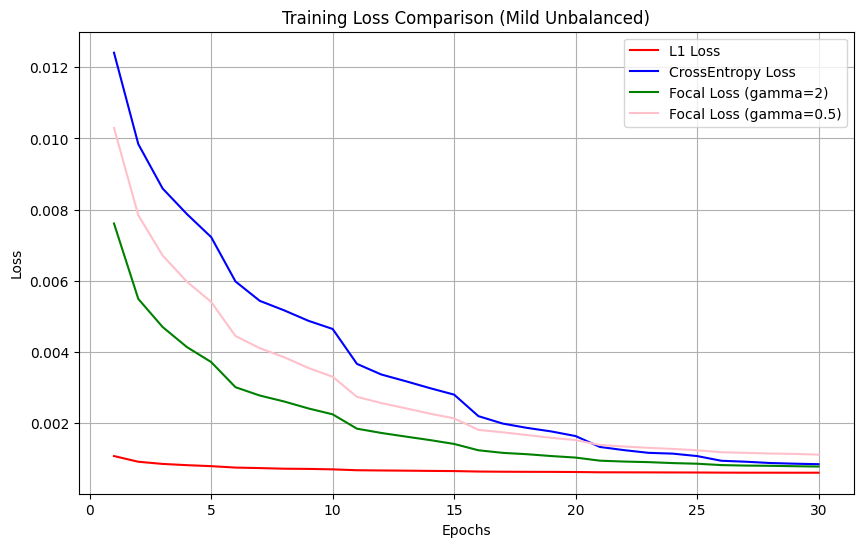

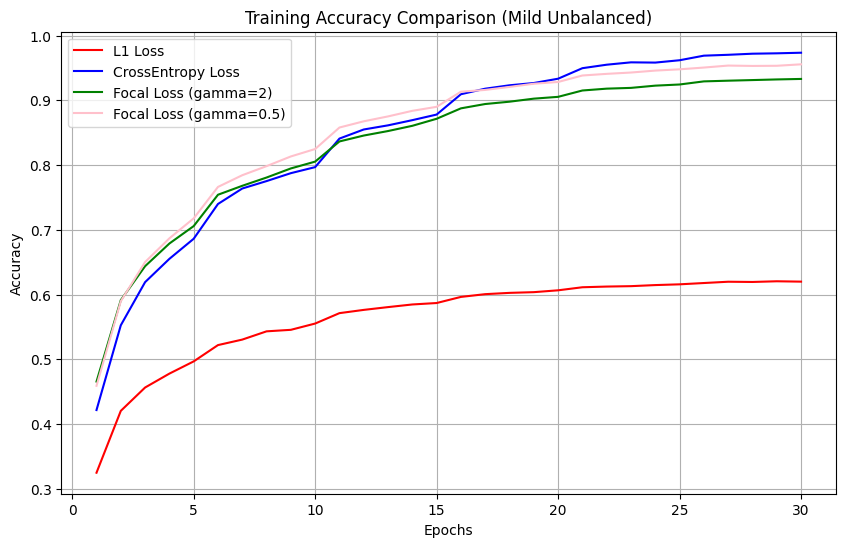

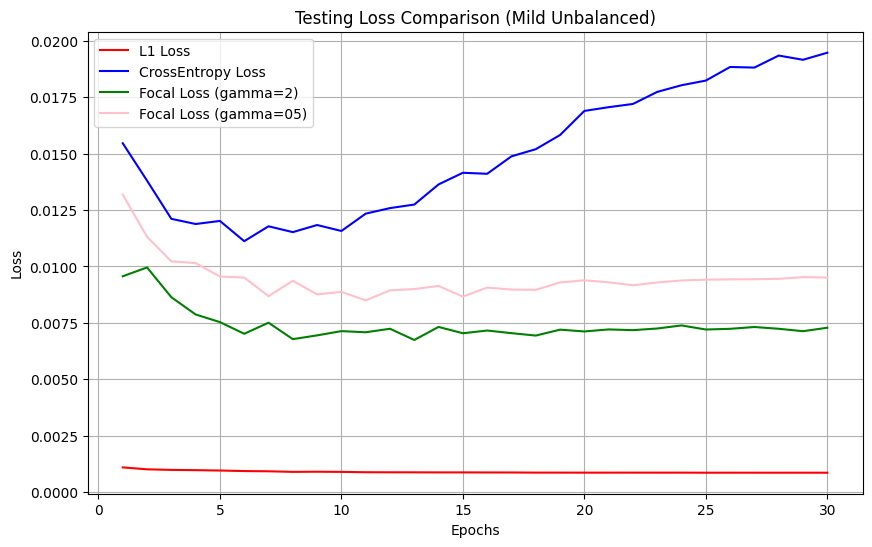

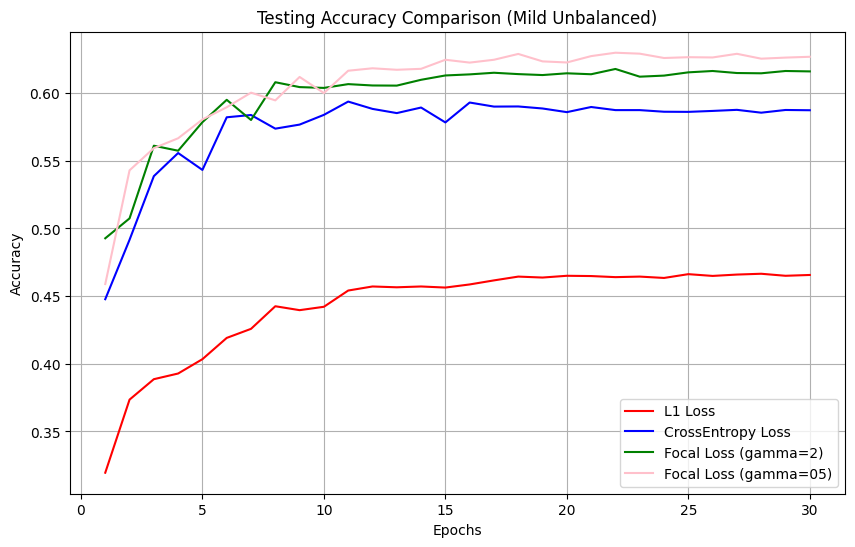

In [30]:
epochs = range(1, len(training_loss_L1) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_loss_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Loss Comparison (Mild Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss__comparison_mild.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_acc_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Accuracy Comparison (Mild Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy_comparison_mild.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_loss_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Loss Comparison (Mild Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss_comparison_mild.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_acc_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Accuracy Comparison (Mild Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy_comparison_mild.png')
plt.show()

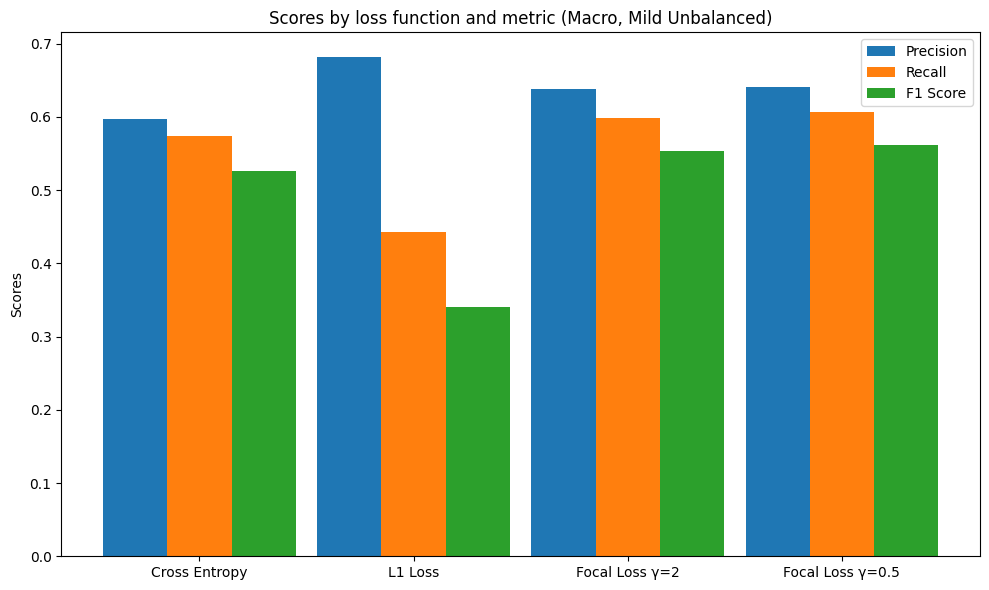

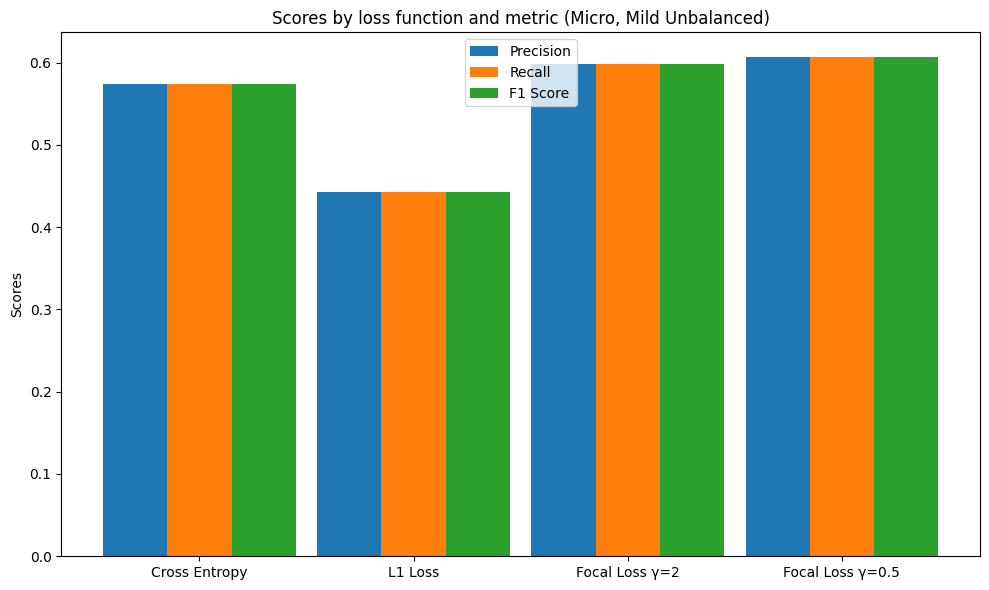

In [31]:


# Marco
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, macro_precisions, width, label='Precision')
rects2 = ax.bar(x, macro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, macro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Macro, Mild Unbalanced)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/macro_scores_mild.png')
plt.show()

# Micro
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, micro_precisions, width, label='Precision')
rects2 = ax.bar(x, micro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, micro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Micro, Mild Unbalanced)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/micro_scores_mild.png')
plt.show()

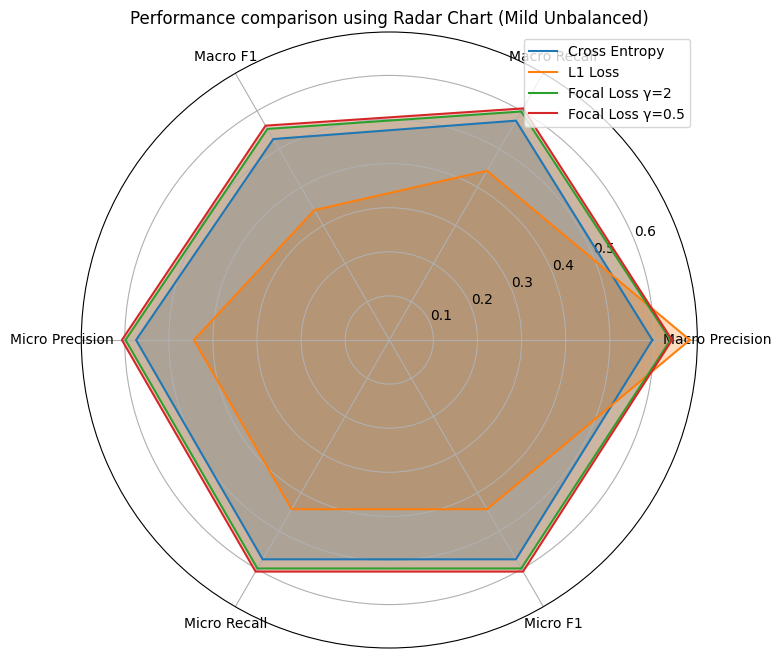

In [32]:

metrics = ['Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1']
values_list = [
    [macro_precision_ce, macro_recall_ce, macro_f1_ce, micro_precision_ce, micro_recall_ce, micro_f1_ce],
    [macro_precision_l1, macro_recall_l1, macro_f1_l1, micro_precision_l1, micro_recall_l1, micro_f1_l1],
    [macro_precision_focal2, macro_recall_focal2, macro_f1_focal2, micro_precision_focal2, micro_recall_focal2, micro_f1_focal2],
    [macro_precision_focal05, macro_recall_focal05, macro_f1_focal05, micro_precision_focal05, micro_recall_focal05, micro_f1_focal05]
]

# draw the Radar Chart
N = len(metrics)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for values, label in zip(values_list, labels):
    values = np.concatenate((values, [values[0]]))  # Close the loop
    ax.plot(theta, values, label=label)
    ax.fill(theta, values, alpha=0.25)

ax.set_xticks(theta[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Performance comparison using Radar Chart (Mild Unbalanced)")
ax.legend(loc='upper right')
plt.savefig('pic/radar_mild.png')
plt.show()

